# Welcome!

We've got some issues we want to resolve.

- [ ] First, we need to fix the data itself. Right now, there are invalid values for some data points (zero or negative) which get pruned off. Because of this, all of the ANOVAs are throwing errors about unbalanced data. We should remove `type = 1` for all `ezANOVA` calls once this is done.
- [ ] Second, we should gather all that data into a readable format that can be placed into the python graph for "Massive Plot of All Benchmarks Distinguishing OSs, averaging ALL videos and kernel sizes"

# Getting Started

In this section, we import the necessary packages and load/transform our data.

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns

# For adding R code to the notebook
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


First, we load in the Docker and native data into arrays of pandas dataframes.

In [80]:
docker_dfs = []
native_dfs = []

# EDIT THESE TWO ARRAYS TO ADD YOUR TEST DATA
folders = ['GZ__Ubuntu__Xeon_E3-1290_V2_3.7GHz_x8__8GB_RAM', 'linux-lt215', 'linux-loaner002', 'GZ__Mac__i9_2.3GHz_x8__16GB_RAM', 'osx-macmini180', 'windows-lt215', 'windows-loaner002']
devices = ['Ubuntu 1', 'Ubuntu 2', 'Ubuntu 3', 'Mac 1', 'Mac 2', 'Windows 1', 'Windows 2']
oss = ['Ubuntu', 'Ubuntu', 'Ubuntu', 'macOS', 'macOS', 'Windows', 'Windows']

for idx, f in enumerate(folders):
  docker_dfs += [[]] # Append empty list
  native_dfs += [[]]
  for i in range(10):
    docker_dfs[idx] += [pd.read_csv(f'../data/{f}/docker-{i}.csv')]
    native_dfs[idx] += [pd.read_csv(f'../data/{f}/native-{i}.csv')]

Next, we combine and reorganize the dataframes into the format below. This format makes it easy to manipulate.

| Device                | Condition | Batch | Run | Benchmark | Source Video | Image Path | Kernel Width (# pixels) | Time Elapsed (milliseconds) | CPU Usage (% of CPU) | Memory Usage (% of memory) |
|-----------------------|-----------|-------|-----|-----------|--------------|------------|-------------------------|-----------------------------|----------------------|----------------------------|
| Macbook Pro 16 (2019) | Docker    | 1     | 1   | resize    | Video 1      | ./path     | 3                       | 55.213                      | 25.0                 | 9.1                        |

In [81]:
# We're going to arrange everything in a massive 2D list
all_dfs_list = []
s = set()

for idx, d in enumerate(devices):    
  # First, get the docker dfs
  for df_index in range(10):
    for _, row in docker_dfs[idx][df_index].iterrows():
      for i in range(1, 11):
        # TODO: fix this!! We should never have negative or zero results.
        if row[f'Time Elapsed {i} (milliseconds)'] <= 0:
          s.add(row['Benchmark'])
          continue
        all_dfs_list += [[
          d,                 # Device
          oss[idx],          # Operating System
          'Docker',          # Condition
          df_index + 1,      # Batch
          i,                 # Run
          df_index * 10 + i, # Trial
          row['Benchmark'],
          row['Source Video'],
          row['Image Path'],
          row['Kernel Width (# pixels)'],
          row[f'Time Elapsed {i} (milliseconds)'],
          math.log10(row[f'Time Elapsed {i} (milliseconds)']),
          row[f'CPU usage {i} (% of CPU)'],
          row[f'memory usage {i} (% of memory)']
        ]]

  # Second, get the native dfs
  for df_index in range(10):
    for _, row in native_dfs[idx][df_index].iterrows():
      for i in range(1, 11):
        # TODO: fix this!! We should never have negative or zero results.
        if row[f'Time Elapsed {i} (milliseconds)'] <= 0:
          s.add(row['Benchmark'])
          continue
        all_dfs_list += [[
          d,                 # Device
          oss[idx],          # Operating System
          'Native',          # Condition
          df_index + 1,      # Batch
          i,                 # Run
          df_index * 10 + i, # Trial
          row['Benchmark'],
          row['Source Video'],
          row['Image Path'],
          row['Kernel Width (# pixels)'],
          row[f'Time Elapsed {i} (milliseconds)'],
          math.log10(row[f'Time Elapsed {i} (milliseconds)']),
          row[f'CPU usage {i} (% of CPU)'],
          row[f'memory usage {i} (% of memory)']
        ]]

print('The following benchmarks have missing values because of negative numbers:', s)

# Finally, make the dataframe to put the data
all_df = pd.DataFrame(data=all_dfs_list, columns=[
  'Device',
  'Operating System',
  'Condition',
  'Batch',
  'Run',
  'Trial', # the overall trial (unique ID)
  'Benchmark',
  'Source Video',
  'Image Path',
  'Kernel Width (# pixels)',
  'Runtime (milliseconds)',
  'LogTime',
  'CPU Usage (% of CPU)',
  'Memory Usage (% of memory)'
])

The following benchmarks have missing values because of negative numbers: {'computeHistogram', 'contrastRandomization', 'meanThresh', 'mirror', 'resize', 'gradientSobel', 'detectSift', 'gaussianBlur', 'rotate'}


In [82]:
all_df.head()

,Device,Operating System,Condition,Batch,Run,Trial,Benchmark,Source Video,Image Path,Kernel Width (# pixels),Runtime (milliseconds),LogTime,CPU Usage (% of CPU),Memory Usage (% of memory)
0,Ubuntu 1,Ubuntu,Docker,1,1,1,measureMemoryUsage,Video2,./data/Video2/Gear5.png and 9 others,3,8.975744,0.953070,14.3,18.1
1,Ubuntu 1,Ubuntu,Docker,1,2,2,measureMemoryUsage,Video2,./data/Video2/Gear5.png and 9 others,3,8.476496,0.928216,14.3,19.9
2,Ubuntu 1,Ubuntu,Docker,1,3,3,measureMemoryUsage,Video2,./data/Video2/Gear5.png and 9 others,3,8.179665,0.912735,14.3,20.0
3,Ubuntu 1,Ubuntu,Docker,1,4,4,measureMemoryUsage,Video2,./data/Video2/Gear5.png and 9 others,3,8.441925,0.926441,0.0,19.9
4,Ubuntu 1,Ubuntu,Docker,1,5,5,measureMemoryUsage,Video2,./data/Video2/Gear5.png and 9 others,3,8.466005,0.927679,14.3,20.3


# Time

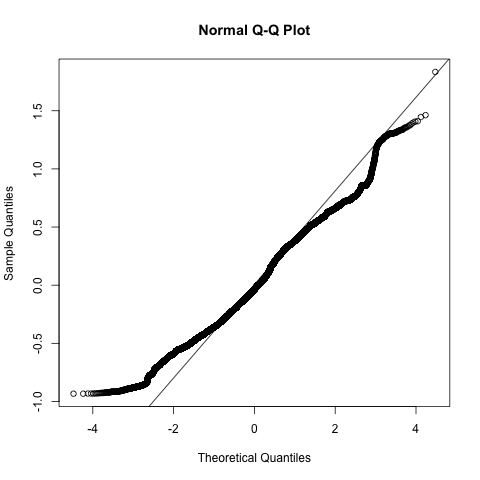

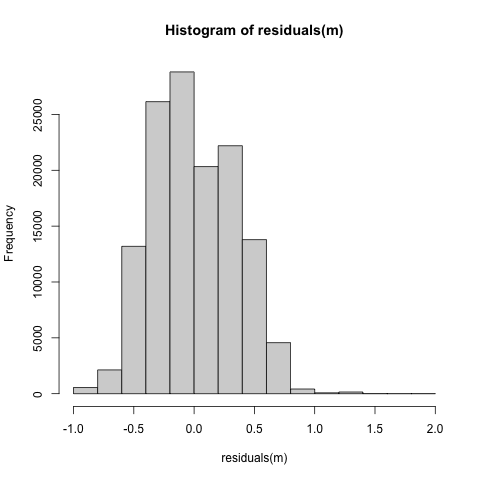

In [83]:
%%R -i all_df

# Sanitize dataframe column names
library(janitor)
all_df <- clean_names(all_df)

all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)

# Use a QQ plot and histogram to check normality
m = aov(log_time ~ condition*benchmark, data=all_df)
qqnorm(residuals(m))
qqline(residuals(m))
hist(residuals(m))

# Anovas

In this section, we perform a series of stats in order to determine whether the differences are significant for various comparisons.

We have the following set of questions we want to ask:
1. Two-way ANOVA with three independent variables: Docker vs Native, Benchmark, and OS. This probably won't show anything useful and it will probably hide a lot of valuable information, but it's a start.
2. For each benchmark, do a two-way ANOVA with two variables: Docker vs Native and OS. This shows any interaction effect.
3. For each benchmark and OS (that's `NUM_OSs * NUM_BENCHMARKS`—it's a lot of tests!), do a one-way ANOVA considering just Docker vs Native. This shows if there is a signficant difference for each column of the massive relative performance graph showing all benches/OSs.

In [85]:
%%R -i all_df

library(tidyverse) # Used for filtering out data irrelevant to a given test
library(janitor) # Fix dataframe column names to sanitize
# Libraries for the ezANOVA
library(ez)
library(apa)
library(lsr)
all_df <- clean_names(all_df)

all_df$device <- factor(all_df$device)
all_df$operating_system <- factor(all_df$operating_system)
all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)
all_df$source_video <- factor(all_df$source_video)
all_df$kernel_width_number_pixels <- factor(all_df$kernel_width_number_pixels)

# print(head(all_df))

# type=1 only if we removed stuff
anoResults <- ezANOVA(data=all_df, type=1, dv=log_time, wid=device, within=c(condition, benchmark), between=operating_system)
print(anoResults)

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                                Effect DFn DFd           F            p p<.05
1                     operating_system   2   4    2.608695 1.883233e-01      
2                            condition   1   4    2.304993 2.035708e-01      
4                            benchmark  15  60 1963.792675 7.838572e-75     *
3           operating_system:condition   2   4   19.411207 8.725246e-03     *
5           operating_system:benchmark  30  60    3.949213 2.989714e-06     *
6                  condition:benchmark  15  60   55.671220 1.806884e-29     *
7 operating_system:condition:benchmark  30  60   13.107656 7.636298e-17     *
         ges
1 0.46838604
2 0.01284726
4 0.99163426
3 0.17978945
5 0.32283801
6 0.45708306
7 0.28389733



## Significance of Docker on Each Benchmark

The following does a TON of anovas (one for each comparison we want to make). The reason this is done as a crapload of separate anovas instead of a single beast is because we can only do a Tukey on a single variable, making it kinda useless for our use case. We want to know if, for each benchmark & os, docker changes performance. So, that's a lot of combinations and each one needs a test somehow!

If somebody knows how to do this better, you are welcome to refactor this. Otherwise, this should calculate everything we need. It does not do all the checks it ought to regarding normality, etc, which may be a weakness.

In [86]:
%%R -i all_df

library(janitor) # Fix dataframe column names to sanitize
all_df <- clean_names(all_df)

library(multcomp)
all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)
all_df$device <- factor(all_df$device)
all_df$operating_system <- factor(all_df$operating_system)

for (b in levels(all_df$benchmark)) {
    bench_df <- filter(all_df, benchmark == b)

    print("------------------------------------------------------------")
    print(b)
    print("------------------------------------------------------------")
    print("--------------------------Overall---------------------------")
    print(ezANOVA(data=bench_df, type=1, dv=log_time, wid=device, within=condition, between=operating_system))
#     m = aov(log_time ~ condition * operating_system, data=bench_df)
#     print(summary(m))
#     print(summary(glht(m, linfct = mcp(condition="Tukey")), test=adjusted(type="holm")))
    
    # For each OS, we do individual ANOVAs for each benchmark
    for (os in levels(individual$operating_system)) {
        print(paste("--------------------------OS: ", os, "---------------------------"))
        os_bench_df <- filter(bench_df, operating_system == os)
        m = aov(log_time ~ condition, data=os_bench_df)
        print(summary(m))
#         print(ezANOVA(data=os_bench_df, type=1, dv=log_time, wid=device, within=condition))
    }
}



[1] "------------------------------------------------------------"
[1] "brightnessRandomization"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F            p p<.05       ges
1           operating_system   2   4  3.192122 0.1483782505       0.6029336
2                  condition   1   4 90.498136 0.0006816127     * 0.5237786
3 operating_system:condition   2   4 43.341991 0.0019456235     * 0.5130286

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1   3.65   3.654   32.79 1.15e-08 ***
Residuals   2398 267.19   0.111                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)  
condition      1    0.5  0.4857    5.12 0.0237 *
Residuals   3598  341.3  0.0949                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq 

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        F         p p<.05        ges
1           operating_system   2   4 1.182751 0.3948706       0.36806212
2                  condition   1   4 3.817764 0.1224067       0.01422537
3 operating_system:condition   2   4 3.567133 0.1290615       0.02625849

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)
condition      1    0.1 0.08749   0.553  0.457
Residuals   2398  379.7 0.15835               
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)
condition      1    0.0 0.00604   0.035  0.851
Residuals   3598  612.5 0.17024               
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1    2.6   2.609   15.26 9.61e-05 ***
Residuals   2398  410.0   0.171                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        F          p p<.05         ges
1           operating_system   2   4 3.134403 0.15173304       0.600844395
2                  condition   1   4 0.202740 0.67584366       0.001998321
3 operating_system:condition   2   4 8.296263 0.03773121     * 0.140799642

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1  17.93  17.926     492 <2e-16 ***
Residuals   2398  87.37   0.036                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1   1.48  1.4813   18.58 1.67e-05 ***
Residuals   3598 286.82  0.0797                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean S

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F          p p<.05       ges
1           operating_system   2   4 0.7587402 0.52557947       0.2467324
2                  condition   1   4 9.9581622 0.03432695     * 0.2537663
3 operating_system:condition   2   4 2.9568490 0.16279783       0.1680171

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1   1.96  1.9589   23.28 1.49e-06 ***
Residuals   2398 201.79  0.0841                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1   0.75  0.7492    11.9 0.000566 ***
Residuals   3598 226.43  0.0629                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd          F           p p<.05       ges
1           operating_system   2   4   2.752891 0.177069689       0.5712779
2                  condition   1   4  61.131477 0.001444388     * 0.3278609
3 operating_system:condition   2   4 101.356899 0.000374439     * 0.6179586

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)   
condition      1    1.4  1.4402   8.594 0.0034 **
Residuals   2398  401.9  0.1676                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)
condition      1    0.0  0.0208   0.169  0.681
Residuals   3598  443.4  0.1232               
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1  118.0  117.97     821 <2e-16 ***
Residuals   

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        F         p p<.05        ges
1           operating_system   2   4 1.040519 0.4326777       0.32908869
2                  condition   1   4 3.693046 0.1270183       0.05014675
3 operating_system:condition   2   4 1.063954 0.4260842       0.02952164

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)
condition      1    0.0  0.0170   0.127  0.722
Residuals   2398  321.1  0.1339               
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1      4   4.020   28.19 1.16e-07 ***
Residuals   3598    513   0.143                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)
condition      1    0.2  0.2494   1.783  0.182
Residuals   2397  335.4

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F           p p<.05        ges
1           operating_system   2   4  3.320587 0.141299564       0.62318312
2                  condition   1   4 32.907859 0.004574257     * 0.03113244
3 operating_system:condition   2   4 11.715748 0.021262826     * 0.02236787

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value  Pr(>F)    
condition      1    7.4   7.429   47.62 6.6e-12 ***
Residuals   2398  374.1   0.156                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)
condition      1    0.0 0.02501   0.145  0.703
Residuals   3598  618.8 0.17199               
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1    2.6  2.6224   18.33 1.93e-05 ***
Re

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd          F            p p<.05        ges
1           operating_system   2   4   2.617304 0.1876216638       0.56440252
2                  condition   1   4  20.599538 0.0105077257     * 0.04850748
3 operating_system:condition   2   4 118.295299 0.0002764157     * 0.36929296

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1   4.22   4.216   41.46 1.45e-10 ***
Residuals   2398 243.83   0.102                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)  
condition      1    0.4  0.3769   3.171  0.075 .
Residuals   3598  427.6  0.1188                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq 

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F           p p<.05       ges
1           operating_system   2   4  2.921639 0.165135532       0.5794736
2                  condition   1   4 28.579048 0.005901709     * 0.2883578
3 operating_system:condition   2   4 44.812239 0.001825329     * 0.5596105

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1   1.22  1.2241   11.62 0.000665 ***
Residuals   2398 252.70  0.1054                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)  
condition      1    0.4  0.4193   3.687 0.0549 .
Residuals   3598  409.2  0.1137                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F va

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        F           p p<.05       ges
1           operating_system   2   4  4.98741 0.081927097       0.6968971
2                  condition   1   4 46.44849 0.002422760     * 0.4752532
3 operating_system:condition   2   4 45.26289 0.001790686     * 0.6383529

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value  Pr(>F)    
condition      1   0.82  0.8236   11.75 0.00062 ***
Residuals   2398 168.12  0.0701                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1   2.15  2.1518   27.54 1.63e-07 ***
Residuals   3598 281.10  0.0781                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd          F            p p<.05       ges
1           operating_system   2   4   8.790791 3.435211e-02     * 0.8023282
2                  condition   1   4 622.641354 1.531227e-05     * 0.9225835
3 operating_system:condition   2   4  46.666606 1.688876e-03     * 0.6411096

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1  23.46  23.465   203.7 <2e-16 ***
Residuals   2398 276.23   0.115                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1  328.1   328.1    3557 <2e-16 ***
Residuals   3598  331.9     0.1                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F          p p<.05        ges
1           operating_system   2   4  4.297522 0.10086039       0.65385150
2                  condition   1   4  2.855833 0.16630828       0.07947076
3 operating_system:condition   2   4 13.928455 0.01576568     * 0.45714483

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1   5.84   5.838   59.05 2.23e-14 ***
Residuals   2398 237.12   0.099                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1    2.1  2.1087   22.79 1.88e-06 ***
Residuals   3598  332.9  0.0925                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq 

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F           p p<.05       ges
1           operating_system   2   4  2.149548 0.232304917       0.5099524
2                  condition   1   4 53.011285 0.001890951     * 0.2963548
3 operating_system:condition   2   4 40.146044 0.002251886     * 0.3894676

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1  18.05  18.049   240.7 <2e-16 ***
Residuals   2398 179.83   0.075                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value  Pr(>F)   
condition      1   0.94  0.9373   10.73 0.00106 **
Residuals   3598 314.21  0.0873                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F va

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F          p p<.05       ges
1           operating_system   2   4  3.511673 0.13167191       0.5671458
2                  condition   1   4 18.318665 0.01284734     * 0.5375104
3 operating_system:condition   2   4  7.011009 0.04926213     * 0.4707914

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1    1.8  1.7966   19.88 8.62e-06 ***
Residuals   2398  216.7  0.0904                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1  108.6  108.62   923.9 <2e-16 ***
Residuals   3598  423.0    0.12                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F 

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F           p p<.05        ges
1           operating_system   2   4  1.060435 0.427064826       0.34032678
2                  condition   1   4  3.698164 0.126823847       0.02435352
3 operating_system:condition   2   4 45.363206 0.001783109     * 0.37979657

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1  37.23   37.23     865 <2e-16 ***
Residuals   2398 103.21    0.04                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)
condition      1   0.09 0.08669   1.454  0.228
Residuals   3598 214.57 0.05963               
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1    9.3   9.299   147.2 <2e-16 ***
Residuals

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F           p p<.05       ges
1           operating_system   2   4  2.808999 0.172961948       0.5517538
2                  condition   1   4 17.828879 0.013451410     * 0.3552007
3 operating_system:condition   2   4 20.174957 0.008134566     * 0.5549061

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1   8.92   8.920   83.56 <2e-16 ***
Residuals   2397 255.88   0.107                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1   14.1   14.10   155.8 <2e-16 ***
Residuals   3598  325.5    0.09                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F va